In [43]:
%matplotlib inline

# London tube dataset provided by: markdunne (github.com/markdunne)
# Bike dataset provided by: Transport for London

import colorsys
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
output_notebook( resources=CDN )
import math
import requests
import json
import time


pd.set_option('max_colwidth', 200)

Loading BokehJS ...

In [44]:
# Tube
lines       = pd.read_csv('london.lines.csv', index_col=0)
stations    = pd.read_csv('london.stations.csv', index_col=0)
stationsRein= pd.read_csv('london.stations.reindexed.csv', index_col=0)
connections = pd.read_csv('london.connections.csv')

# Bikes
bikeTripData = pd.read_csv('bikes/london-bikes-sorted.csv', index_col=0)       # http://cycling.data.tfl.gov.uk
bikeDockingStations = pd.read_csv('santander-cycle-coords.csv', index_col=0)   # https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml

# Uber
uberTripData = pd.read_csv('../uber/compiledUberData.csv', index_col=0)       # Uber API



In [45]:
# Divide bike data into different files for quicker processing
# or rather, store indices of start/stop of data.
startOfBikeDataStartStationSection = {}
startOfBikeDataStartStationSection[1] = 0

currId = 1
for station_id, station in bikeTripData.iterrows():
    if currId == station["StartStation Id"]:
        continue
    else:
        startOfBikeDataStartStationSection[currId+1] = station_id
        currId = currId + 1
        

In [143]:
# Example Shortest Path
nx.shortest_path(tubeGraph, 'Oxford Circus', 'Canary Wharf', weight='time')

['Oxford Circus',
 'Oxford Circus - Victoria Line',
 'Green Park - Victoria Line',
 'Green Park - Jubilee Line',
 'Westminster - Jubilee Line',
 'Waterloo - Jubilee Line',
 'Southwark - Jubilee Line',
 'London Bridge - Jubilee Line',
 'Bermondsey - Jubilee Line',
 'Canada Water - Jubilee Line',
 'Canary Wharf - Jubilee Line',
 'Canary Wharf']

In [47]:
# You can do graphs things on the graph.
nx.algorithms.connectivity.cuts.minimum_node_cut(tubeGraph)

{'Belsize Park - Northern Line'}

In [48]:
bikeDockingStations
#bikeDockingStations.get_value(4,"station__name")
#bikeTripData

station__name  \
station__id                                                  
1                               River Street , Clerkenwell   
2                           Phillimore Gardens, Kensington   
3                     Christopher Street, Liverpool Street   
4                          St. Chad's Street, King's Cross   
5                            Sedding Street, Sloane Square   
6                           Broadcasting House, Marylebone   
7                        Charlbert Street, St. John's Wood   
8                                   Maida Vale, Maida Vale   
9                                 New Globe Walk, Bankside   
10                                   Park Street, Bankside   
11                            Brunswick Square, Bloomsbury   
12                                Malet Street, Bloomsbury   
13                                 Scala Street, Fitzrovia   
14                          Belgrove Street , King's Cross   
15                        Great Russell Street, Bloomsbury   
16                         Cartwright Gardens , Bloomsbury   
17                                    Hatton Wall, Holborn   
18                               Drury Lane, Covent Garden   
19                              Taviton Street, Bloomsbury   
21                        Hampstead Road (Cartmel), Euston   
22                            Northington Street , Holborn   
23                                Red Lion Square, Holborn   
24                              British Museum, Bloomsbury   
25                                 Doric Way , Somers Town   
26                             Ampton Street , Clerkenwell   
27                                 Bouverie Street, Temple   
28                              Bolsover Street, Fitzrovia   
29                                Hereford Road, Bayswater   
30                                 Windsor Terrace, Hoxton   
31                                  Fanshaw Street, Hoxton   
...                                                    ...   
802                               Albert Square, Stockwell   
803                             Southwark Street, Bankside   
804                               Good's Way, King's Cross   
805                       Bevington Road, North Kensington   
806                         Handyside Street, King's Cross   
807                  Bevington Road West, North Kensington   
808                        Stockwell Roundabout, Stockwell   
809                          Lincoln's Inn Fields, Holborn   
810                                  Tate Modern, Bankside   
811                         Westferry Circus, Canary Wharf   
812          Here East North, Queen Elizabeth Olympic Park   
813                      New Spring Gardens Walk, Vauxhall   
814                Clapham Road, Lingham Street, Stockwell   
815                          Lambeth Palace Road, Waterloo   
816          Here East South, Queen Elizabeth Olympic Park   
817                            Riverlight South, Nine Elms   
818                           One Tower Bridge, Bermondsey   
819                           Belvedere Road 2, South Bank   
820                                Victory Place, Walworth   
821                Battersea Power Station, Battersea Park   
826                             Allington Street, Victoria   
828                               Normandy Road, Stockwell   
829                                  Wynne Road, Stockwell   
830                                 Sidney Road, Stockwell   
831                            St John's Crescent, Brixton   
832                                Ferndale Road, Brixton.   
833                                  Saltoun Road, Brixton   
835                             Farringdon Street, Holborn   
836                                  York Way, Kings Cross   
838                          Fore Street Avenue, Guildhall   

             station__terminalName  station__lat  station__long  \
station__id                                                       
1   

In [49]:
# Calculate the farthest bike station from the center.
maxDistance = 0
maxStationName = ''
maxStationId = -1

# Center of London
center = (51.510776, -0.115638)

for id, station in bikeDockingStations.iterrows():
    
    Lat = station["station__lat"]
    Long = station["station__long"]
    Distance = math.sqrt((Lat*(11/7))**2 + (Long)**2)
    
    if Distance > maxDistance:
        maxStationName = station["station__name"]
        maxStationId = id
        maxDistance = Distance
        
print("Furthest Docking Station:",maxStationName, " - ",maxStationId)
print(bikeDockingStations.at[maxStationId,"station__lat"], bikeDockingStations.at[maxStationId,"station__long"])



Furthest Docking Station: Lee Valley VeloPark, Queen Elizabeth Olympic Park  -  786
51.549369 -0.015717613999999998


In [50]:
###################### START OF THE COMPUTATION #####################

In [51]:
# ------------- Get Random value and Mean -----------------

def randomCoordinate():
    # Calcuates mean coordinates based on Tube Stations
    latcoors = stationsRein['latitude']
    longcoors = stationsRein['longitude']
    latmean = latcoors.mean()
    longmean = longcoors.mean()

    meancoors = (latmean, longmean)
    meancoors = (51.510776, -0.115638) # Center of London
    # print("Mean Coordinates: ", meancoors)

    latitudeBoundSize = 0.03  # Mess with these for bigger radius
    longitudeBoundSize = 0.1  # Mess with these for bigger radius

    randLat1 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
    randLong1 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))
    randLat2 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
    randLong2 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))

    print("Random origin location:        ", randLat1,"," ,randLong1)
    print("Random destination location:   ", randLat2,",", randLong2)
    
    return randLat1, randLong1, randLat2, randLong2

In [52]:
def getRandomBikeTrip():
    
    randIdx = -1
    dataPotentiallyDangerous = True
    while (dataPotentiallyDangerous):
        # Get random index between 0 and size of bikeTripData
        randIdx = random.randint(0,len(bikeTripData))
        
        dataPotentiallyDangerous = False
        
        # Try it
        try:
            randomStationId1 = int(bikeTripData.at[int(randIdx),"StartStation Id"])
            randomStationId2 = int(bikeTripData.at[int(randIdx),"EndStation Id"])
            bikeDockingStations.at[int(randomStationId1), "station__lat"]
            bikeDockingStations.at[int(randomStationId2), "station__lat"]
    
        except Exception:
            dataPotentiallyDangerous = True
            
        
    
    
    # Choose a random bike trip
    randomStationId1 = int(bikeTripData.at[int(randIdx),"StartStation Id"])
    randomStationId2 = int(bikeTripData.at[int(randIdx),"EndStation Id"])
    randomTripDuration = int(bikeTripData.at[int(randIdx),"Duration"])

    
    # Get the latitude and longitude of a trip
    randLat1  =  bikeDockingStations.at[int(randomStationId1), "station__lat"]
    randLong1 =  bikeDockingStations.at[int(randomStationId1), "station__long"]
    randLat2  =  bikeDockingStations.at[int(randomStationId2), "station__lat"]
    randLong2 =  bikeDockingStations.at[int(randomStationId2), "station__long"]
        
    
#     print(randomStationId1)
#     print(randomStationId2)
#     print(randomTripDuration/60)
    
    
    # Calculate the distance in miles.
    coorDistance = math.sqrt((randLat1 - randLat2)**2 + ((randLong1 - randLong2)*(70/111))**2)*(68.9722)
    
#     print(coorDistance)
    
    return randLat1, randLong1, randLat2, randLong2, randomStationId1, randomStationId2, coorDistance
    
    
getRandomBikeTrip()
    

(51.46663393,
 -0.169821175,
 51.47518024,
 -0.167160736,
 638,
 620,
 0.6007089567327973)

In [53]:
# --------------- Calculates the closest TUBE stations to the random coordinates --------------

def closestTubeStation(randLat1, randLong1, randLat2, randLong2):
    #calculate distances to all stations in array from co-ordinates
    tubeDistances1 = []
    tubeDistances2 = []
    for i in range(1, len(stationsRein['longitude'])):
        distance1 = math.sqrt(((randLat1 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong1 - stationsRein['longitude'].iloc[i-1])**2)
        distance2 = math.sqrt(((randLat2 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong2 - stationsRein['longitude'].iloc[i-1])**2)

        tubeDistances1.append(distance1)
        tubeDistances2.append(distance2)

    #pick shortest for each co-ordinate
    station1 = tubeDistances1.index(min(tubeDistances1))
    station2 = tubeDistances2.index(min(tubeDistances2))
    
    oName = stationsRein['name'][station1+1]
    oLat  = stationsRein['latitude'][station1+1]
    oLong = stationsRein['longitude'][station1+1]
    
    dName = stationsRein['name'][station2+1]
    dLat  = stationsRein['latitude'][station2+1]
    dLong = stationsRein['longitude'][station2+1]

    print("Nearest train station to Random Origin:",oName,oLat,oLong)
    print("Nearest train station to Random Destination:",dName,dLat,dLong)
    
    return oName, dName
    #return oName,oLat,oLong,dName,dLat,dLong

In [54]:
# ---------------- Calculate the closest BIKE station to the random coordinates ---------------

def closestBikeStation(randLat1, randLong1, randLat2, randLong2):

    shortestOriginID = -1
    shortestDestID = -1
    
    shortestBikeOriginValue = 9999
    shortestBikeDestinationValue = 9999

    for st_id, dockingStation in bikeDockingStations.iterrows():
        dockingID = st_id
        dockingLat  = dockingStation["station__lat"]
        dockingLong = dockingStation["station__long"]
        distanceFromRandomToOrigin      = math.sqrt(((randLat1 - dockingLat)*11/7)**2 + (randLong1 - dockingLong)**2)
        distanceFromRandomToDestination = math.sqrt(((randLat2 - dockingLat)*11/7)**2 + (randLong2 - dockingLong)**2)

        if distanceFromRandomToOrigin < shortestBikeOriginValue:
            shortestOriginID = dockingID
            shortestBikeOriginValue = distanceFromRandomToOrigin

        if distanceFromRandomToDestination < shortestBikeDestinationValue:
            shortestDestID = dockingID
            shortestBikeDestinationValue = distanceFromRandomToDestination

    print("Nearest bike station to Random Origin:", shortestOriginID)
    print("Nearest bike station to Random Destination:", shortestDestID)
    
    return shortestOriginID, shortestDestID

In [55]:
# ------------- Calculate BIKE travel time -----------------------
# Calculates the mean of the closest bike ports, as well as ones that are really close.

def calcBikeTravelTimeMins(oBikeStationID, dBikeStationID):
    exactMatches = 0
    #relativeMatches = 0
    totalDurationAllTrips = 0
    
    # Get the range of samples to look at 
    # As an optimization, only looked at the subset of data with the curent station station.
    try:
        lowerBound = startOfBikeDataStartStationSection[oBikeStationID]
        upperBound = startOfBikeDataStartStationSection[oBikeStationID +1] - 1
    except Exception:
        return -1
    
    if lowerBound == 0:
        lowerBound = 1
    
    print(oBikeStationID,lowerBound,upperBound)
    
    for i in range(lowerBound, upperBound):

        # Extract the trip data.
        tStartName =  bikeTripData.at[int(i),"StartStation Name"]
        tStartID =    bikeTripData.at[int(i),"StartStation Id"]

        tEndName   =  bikeTripData.at[int(i),"EndStation Name"]
        tEndID =  bikeTripData.at[int(i),"EndStation Id"]
        
        tDuration = bikeTripData.at[int(i),"Duration"]
        
        # If this trip exactly matches the given origin and dest.
        if oBikeStationID == tStartID and dBikeStationID == tEndID:
            exactMatches += 1
            totalDurationAllTrips += tDuration
            
            
    print("For bikes there were:",exactMatches, "exact matches.")
#   print("For bikes there were:",relativeMatches, "relative matches.")
    
    if exactMatches == 0:
        return -1 # ERROR! No matches...
    
    bikeMins = (totalDurationAllTrips / (exactMatches))/60
    print("The average time of this BIKE trip is:", bikeMins, "minutes.")
    
    
    return bikeMins

In [56]:
# --------------- Calculate TRAIN travel time --------------
# Calculates with dijkstra's shortest path algorithm (weighted by TIME)
def calcTrainTravelTimeMins(oName, dName):
    
    #nx.algorithms.shortest_paths.dijkstra_path(tubeGraph, oName, dName)

    quickestTrainTime = nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph,oName,dName, weight = "time")

    print("The quickest time for this TRAIN trip is ",quickestTrainTime, "minutes.")
    
    return quickestTrainTime

In [57]:
#### ------ Calculate how far the trip actually is------- ####

#distance1 = math.sqrt(((randLat1 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong1 - stationsRein['longitude'].iloc[i-1])**2)
#distance2 = math.sqrt(((randLat2 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong2 - stationsRein['longitude'].iloc[i-1])**2)

In [58]:
# Old "Run"

# ########## RUN ME ############
# numIterations = 1000


# ##############################

# mainTestOutput = {}
# for i in range(0, numIterations):
#     print("[!] Iteration", i)
#     # Compute random coordinates in our range
#     #(randLat1, randLong1, randLat2, randLong2) = randomCoordinate()
#     (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()

#     # Calculate the nearest origin and destination stations, given the random coordinates.
#     (oTrain,dTrain) = closestTubeStation(randLat1, randLong1, randLat2, randLong2)
# ##    (oBike, dBike) = closestBikeStation(randLat1, randLong1, randLat2, randLong2)

#     # Calculate the minimum/average travel time (with our data) given an origin and a destination.
#     trainMins = calcTrainTravelTimeMins(oTrain,dTrain)
#     bikeMins = calcBikeTravelTimeMins(oBike, dBike)

#     if bikeMins == -1 or trainMins == -1:
#         print("error")
#         continue
        
#     mainTestOutput[i] = {"oRandomLat": randLat1,
#                  "oRandomLong": randLong1,
#                  "dRandomLat": randLat2,
#                  "dRandomLong": randLong2,
#                  "coorDistance": coorDistance,
#                  "oTrain": oTrain, 
#                  "dTrain": dTrain,
#                  "oBike": oBike,
#                  "dBike": dBike,
#                  "bikeMins": bikeMins,
#                  "trainMins": trainMins}
    



In [59]:
# mainTestOutputDF = pd.DataFrame.from_dict(mainTestOutput, orient="index")
# mainTestOutputDF

In [60]:
# Save data to csv file.
# mainTestOutputDF.to_csv("./londonComputedData/computedData.csv")


In [61]:
#calcBikeTravelTimeMins(751,95)
#bikeDockingStations.at[int(4),"station__lat"]
#bikeTripData

In [62]:
# Visualization

# clean_data = mainTestOutputDF.copy(deep = True)
# cols = ['bikeMins', 'trainMins']
# for i in cols:
#     clean_data = clean_data[clean_data[i] <= 100]

In [63]:
# clean_data2 = mainTestOutputDF.copy(deep = True)
# cols = ['bikeMins', 'trainMins']
# for i in cols:
#     clean_data2 = clean_data2[clean_data2['coorDistance']/clean_data2[i] >= 0.1]
#     #clean_data = clean_data[clean_data[i] <= 100]

In [64]:
# plt.scatter(x = mainTestOutputDF['coorDistance'], y = mainTestOutputDF['bikeMins'])
# plt.scatter(x = mainTestOutputDF['coorDistance'], y = mainTestOutputDF['trainMins'])

In [65]:
# plt.scatter(x = clean_data2['coorDistance'], y = clean_data2['bikeMins'], alpha = 0.1)
# plt.scatter(x = clean_data2['coorDistance'], y = clean_data2['trainMins'], alpha = 0.1)

In [66]:
#quickestTrainTime = nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph,oName,dName, weight = "time") + math.floor(nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph, oName, dName)/3)*3

In [67]:
# Determine which trips were faster riding a bike

# tripsFasterWithBike = 0
# for t_id, trip in mainTestOutputDF.iterrows():
#     if trip['trainMins'] > trip['bikeMins']:
#         tripsFasterWithBike = tripsFasterWithBike + 1
        
# print("There are:", tripsFasterWithBike, "Faster trips with a bike out of", len(mainTestOutputDF) ,"trips.")

In [68]:
#  Get the coordinates of lots of possible bike trips
#  Use this to compile the Uber data.
def computeSetOfCoords():
    setOfCoordinates = {}
    for i in range(0,100):
        (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()
        setOfCoordinates[i] = {"randLat1":randLat1, "randLong1":randLong1, "randLat2":randLat2, "randLong2":randLong2, "oBike":oBike, "dBike":dBike, "coorDistance":coorDistance}

    setOfCoordinatesDF = pd.DataFrame.from_dict(setOfCoordinates, orient="index")
    setOfCoordinatesDF.to_csv("../uber/setOfCoordinates.csv")
    
    return setOfCoordinatesDF

#setOfCoordinatesDF

In [69]:
# Fetches equivalant trip data for uber rides by asking the Uber API directly.  
def askUberForInfo():
    
    uberResults = {}
    uberRawResults = {}
    tokens = ["JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAANtHflT8X6DoYgIpCEVvhHRsAAAA2UI88meKNaFqi1aP8LM1syhGcTLmrN3bvmRGohrWvljT6ALAFnJJKdfgTlqnnl50IsXy1CwvcUQTysW5bpMrhGFKOokiYeaMZpxikirFh12Vyrf9mmLsSL0vfx3wg820TuLjp6GGxAoU6tInDAAAAJDaK7uypaWVZxNPcSQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU", 'JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAAM_yxbT1BPzwSOymOXStGetsAAAAurbsvx8OqXR8FI774FPoE9iTS93TFkHrFEjA_FOAAufTRMemHv0eMmLuSkRvONJBQEX5ESAzxYyq-DZJjxJiCPUXRLRBwSQ_LzYQJN4JURYF7G70x8oGJXOGGof8fAswKOfA7RtKsbaIy-PfDAAAAE0SqVeUlRC5cN9KryQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU','JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAAMswH7vSMNlBOXSNVxsX7BJsAAAACKszwJhNzfFi2nPv1m7aCbCPeTFFG6ntVaw6dAoUnwa47cTsDmK6jpnSh6kVOJXPhGRDVCAZXh-2iHslwDj7_x1FsyhO4nl7S0pxfVN4zFfk7v1-gBsY_-5z9gNZl6jQ70qVXQSy5YLMwvv5DAAAAJ0myYCyXBVu-jv69yQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU']
    idx = 0
    
    for token in tokens:
        setOfCoordinatesDF = computeSetOfCoords()
        for e_idx, element in setOfCoordinatesDF.iterrows():
            
            if (element["oBike"] == element["dBike"]):
                continue


            a = element['randLat1']
            b = element['randLong1']
            c = element['randLat2']
            d = element['randLong2']
            
            tokenStr = "Bearer " + token

            data = json.dumps({"start_latitude": a,"start_longitude": b,"end_latitude": c,"end_longitude": d})
            headers = {'Content-Type': 'application/json', 'Authorization': tokenStr}
            r = requests.post('https://api.uber.com/v1.2/requests/estimate', headers=headers, data=data)

            response = r.json()
            print(r.status_code, "for #", idx)

            if (r.status_code != 200):
                print("Encountered Error with API on iteration", idx)
                print(response)
                break

            uberTripTime = response["trip"]["duration_estimate"]
            uberTripDistance = response["trip"]["distance_estimate"]
            uberTripValue = response['estimate']['display']
            
            
            # Increment Global index
            idx = idx + 1

            uberResults[idx] = {"originBikeStation": int(element["oBike"]), 
                                  "destBikeStation": int(element["dBike"]), 
                                  "uberTripTime":uberTripTime, 
                                  "uberTripDistance": uberTripDistance, 
                                  "uberTripValue": uberTripValue}

            uberRawResults[idx] = response

        uberResultsDF = pd.DataFrame.from_dict(uberResults, orient="index")
        rawUberResultsDF = pd.DataFrame.from_dict(uberRawResults, orient="index")
        timeStamp = int(time.time())
        uberResultsDF.to_csv("../uber/uberResults" + str(timeStamp) + ".csv")
        rawUberResultsDF.to_csv("../uber/uberRawResults" + str(timeStamp) + ".csv")

    return uberResultsDF, rawUberResultsDF



In [70]:
# RUNS API SCRIPT
# Generate a set of coordinates that is a valid trips on bikes
# Calculate an equivalant trip with Uber by asking Uber's API.  (Gets the price and travel time)

uberResultsDF, rawUberResultsDF = askUberForInfo()



429 for # 0
Encountered Error with API on iteration 0
{'message': 'Exceeded rate limit', 'code': 'rate_limited'}
429 for # 0
Encountered Error with API on iteration 0
{'message': 'Exceeded rate limit', 'code': 'rate_limited'}
429 for # 0
Encountered Error with API on iteration 0
{'message': 'Exceeded rate limit', 'code': 'rate_limited'}


In [71]:
# Put all the trip data into one CSV
# uberResultsDF

Empty DataFrame
Columns: []
Index: []

In [72]:
########## MAIN EXPERIMENT WITH UBER #######
# Iterates through uber trip data, 
# using the stored origin station and destination to calculate bike and train trips.

mainTestOutputWithUber = {}


### RUNNING ON A PRE-MADE DATASET LOADED IN THE BEGINNING
for u_id, uberTrip in uberTripData.iterrows():
    print("[!] Iteration", u_id)

    # (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()
    oBike = uberTrip['originBikeStation']
    dBike = uberTrip['destBikeStation']
    
    uberTripTime = uberTrip['uberTripTime']
    uberTripDistance = uberTrip['uberTripDistance']
    uberTripValue = uberTrip['uberTripValue']
    
    originLat  =  bikeDockingStations.at[oBike, "station__lat"]
    originLong =  bikeDockingStations.at[oBike, "station__long"]
    destLat  =    bikeDockingStations.at[dBike, "station__lat"]
    destLong =    bikeDockingStations.at[dBike, "station__long"]
    
    # Calculate the nearest origin and destination stations, given the random coordinates.
    (oTrain,dTrain) = closestTubeStation(originLat, originLong, destLat, destLong)

    # Calculate the minimum/average travel time (with our data) given an origin and a destination.
    trainMins = calcTrainTravelTimeMins(oTrain,dTrain)
    bikeMins = calcBikeTravelTimeMins(oBike, dBike)

    if bikeMins == -1 or trainMins == -1:
        print("error")
        continue
    
    uberMins = 0
    if uberTripTime > 0:
        uberMins = uberTripTime / 60    
        
    mainTestOutputWithUber[u_id] = {
        "oLat": originLat,
        "oLong": originLong,
        "dLat": destLat,
        "dLong": destLong,
        "uberTripDistance": uberTripDistance,
        "uberTripValue": uberTripValue,
        "oTrain": oTrain, 
        "dTrain": dTrain,
        "oBike": oBike,
        "dBike": dBike,
        "bikeMins": bikeMins,
        "trainMins": trainMins,
        "uberMins": uberMins}
    
mainTestOutputWithUberDF = pd.DataFrame.from_dict(mainTestOutputWithUber, orient="index")

[!] Iteration 0
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  8 minutes.
88 44246 44838
For bikes there were: 47 exact matches.
The average time of this BIKE trip is: 8.23404255319149 minutes.
[!] Iteration 1
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  8.5 minutes.
46 24042 24809
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 7.25 minutes.
[!] Iteration 2
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  12.0 minutes.
169 84333 84903
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 6.6 minutes.
[!] Ite

For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 9.733333333333333 minutes.
[!] Iteration 26
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  13.5 minutes.
14 5428 8543
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 16.25 minutes.
[!] Iteration 27
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  11.0 minutes.
372 173953 174333
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
[!] Iteration 28
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  10.5 minut

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 9.2 minutes.
[!] Iteration 52
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  3 minutes.
755 290132 290666
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 4.5 minutes.
[!] Iteration 53
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  15.0 minutes.
288 140184 140757
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 25.2 minutes.
[!] Iteration 54
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  11.0 minutes.
717 278315 279124
For bikes there were: 13 exact m

The quickest time for this TRAIN trip is  9.0 minutes.
722 280472 280747
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 77
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  14.5 minutes.
117 60399 60759
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 21.5 minutes.
[!] Iteration 78
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  9.5 minutes.
55 28212 29513
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 13.2 minutes.
[!] Iteration 79
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAI

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 104
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  4 minutes.
215 107098 108057
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 9.214285714285715 minutes.
[!] Iteration 105
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  4 minutes.
124 63096 63378
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 9.8 minutes.
[!] Iteration 106
Nearest train station to Random Origin: East India 51.5093 -0.0021
Nearest train station to Random Destination: Poplar 51.5077 -0.0173
The quickest time for this TRAIN trip is  6 minutes.
547 229221 229381
For bikes there were: 24 exact matches.

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.666666666666666 minutes.
[!] Iteration 132
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  12.0 minutes.
699 273203 273425
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 133
Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  10 minutes.
794 302723 302787
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 23.5 minutes.
[!] Iteration 134
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  6.5 minutes.
197 99042 99546
For bikes there were: 

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 157
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Charing Cross 51.508 -0.1247
The quickest time for this TRAIN trip is  14.0 minutes.
574 237025 237996
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 24.333333333333332 minutes.
[!] Iteration 158
Nearest train station to Random Origin: Mornington Crescent 51.5342 -0.1387
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  6 minutes.
362 171499 171830
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 3.4090909090909087 minutes.
[!] Iteration 159
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  11.5 minutes.
358 16

Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  14 minutes.
290 140957 141740
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 18.714285714285715 minutes.
[!] Iteration 183
Nearest train station to Random Origin: Regent's Park 51.5234 -0.1466
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  9.5 minutes.
242 120334 120717
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.5 minutes.
[!] Iteration 184
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  14.0 minutes.
213 105171 106451
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 54.8 minutes.
[

For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 11.631578947368421 minutes.
[!] Iteration 215
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  11 minutes.
84 42626 42955
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 216
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  11.0 minutes.
191 92980 94943
For bikes there were: 98 exact matches.
The average time of this BIKE trip is: 38.66326530612245 minutes.
[!] Iteration 217
Nearest train station to Random Origin: Kensington (Olympia) 51.4983 -0.2106
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  13.5 minu

Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Pudding Mill Lane 51.5343 -0.0139
The quickest time for this TRAIN trip is  4 minutes.
790 301658 301985
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 12.444444444444445 minutes.
[!] Iteration 246
Nearest train station to Random Origin: Devons Road 51.5223 -0.0173
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  14.5 minutes.
499 214332 214656
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.666666666666666 minutes.
[!] Iteration 247
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  0 minutes.
139 70578 70833
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 4.333333333333333 minutes.
[

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 274
Nearest train station to Random Origin: Temple 51.5111 -0.1141
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  10 minutes.
174 86115 86648
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 275
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Bow Road 51.5269 -0.0247
The quickest time for this TRAIN trip is  3 minutes.
492 212707 213360
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 276
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  8.5 minutes.
639 256468 256824
For bikes there were: 1 exact matches.
Th

The average time of this BIKE trip is: 5.1 minutes.
[!] Iteration 306
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  6.5 minutes.
757 291026 291401
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 307
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  28.0 minutes.
735 285004 285403
For bikes there were: 45 exact matches.
The average time of this BIKE trip is: 3.8666666666666667 minutes.
[!] Iteration 308
Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Westminster 51.501000000000005 -0.1254
The quickest time for this TRAIN trip is  12.5 minutes.
802 305680 305985
For b

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 37.0 minutes.
[!] Iteration 335
Nearest train station to Random Origin: Kennington 51.4884 -0.1053
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  10.5 minutes.
86 43519 43750
For bikes there were: 36 exact matches.
The average time of this BIKE trip is: 3.888888888888889 minutes.
[!] Iteration 336
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  6.5 minutes.
503 215454 215973
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 4.4 minutes.
[!] Iteration 337
Nearest train station to Random Origin: Bank 51.5133 -0.0886
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  4 minutes.
340 160931 161844
For bikes there were: 15 e

The quickest time for this TRAIN trip is  21.5 minutes.
243 120718 121080
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 47.0 minutes.
[!] Iteration 363
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  9.0 minutes.
792 301987 302452
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 364
Nearest train station to Random Origin: Farringdon 51.5203 -0.1053
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  6.5 minutes.
393 182577 183150
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 8.666666666666666 minutes.
[!] Iteration 365
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.175

For bikes there were: 90 exact matches.
The average time of this BIKE trip is: 3.3 minutes.
[!] Iteration 394
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  6 minutes.
218 109857 110287
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 395
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  9.5 minutes.
185 90565 90962
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 65.0 minutes.
[!] Iteration 396
Nearest train station to Random Origin: Euston Square 51.526 -0.1359
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  6.5 minutes.
19 11152 11572
For bikes there were: 2 exact matches

Nearest train station to Random Origin: Regent's Park 51.5234 -0.1466
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  9.5 minutes.
581 239764 240218
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 422
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  7.5 minutes.
324 154878 155295
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 4.666666666666667 minutes.
[!] Iteration 423
Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  14 minutes.
229 115183 116065
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 33.333333333333336 minutes.


Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  10.0 minutes.
815 309156 309646
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 15.428571428571427 minutes.
[!] Iteration 451
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Embankment 51.5074 -0.1223
The quickest time for this TRAIN trip is  11.5 minutes.
294 142687 143160
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 452
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  14.5 minutes.
613 248711 249241
For bikes there were: 33 exact matches.
The average time of this BIKE trip is: 6.484848484848484

Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  10.5 minutes.
94 46351 46833
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 480
Nearest train station to Random Origin: Putney Bridge 51.4682 -0.2089
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  7 minutes.
774 296575 296692
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 481
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  6 minutes.
614 249242 249414
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 9.25 minutes.
[!] Iteration 482
Nearest train station to 

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 3.6666666666666665 minutes.
[!] Iteration 510
Nearest train station to Random Origin: Bank 51.5133 -0.0886
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  7 minutes.
340 160931 161844
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 19.09090909090909 minutes.
[!] Iteration 511
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  10.5 minutes.
359 169272 169564
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 16.2 minutes.
[!] Iteration 512
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  12 minutes.
101 50037 51387
For 

Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  9.0 minutes.
121 62067 62426
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 539
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  15.5 minutes.
732 283297 284519
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 540
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  12.0 minutes.
452 201611 202007
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 541
Nearest train station to Ran

Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  8.5 minutes.
202 101245 102142
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 5.166666666666667 minutes.
[!] Iteration 569
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  11.5 minutes.
282 138500 139177
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 58.4 minutes.
[!] Iteration 570
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  9.5 minutes.
215 107098 108057
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 8.647058823529413 minutes.
[!] Iteration 

Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  8 minutes.
258 128310 128474
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 116.2 minutes.
[!] Iteration 599
Nearest train station to Random Origin: Euston Square 51.526 -0.1359
Nearest train station to Random Destination: Leicester Square 51.5113 -0.1281
The quickest time for this TRAIN trip is  10.5 minutes.
69 35276 35623
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 12.285714285714285 minutes.
[!] Iteration 600
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Bank 51.5133 -0.0886
The quickest time for this TRAIN trip is  4 minutes.
449 200535 201046
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 10.571428571428573 minutes.
[!] 

Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  11.0 minutes.
646 258397 258902
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 15.8 minutes.
[!] Iteration 630
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  0 minutes.
698 272899 273202
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 631
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  10.0 minutes.
67 34181 34717
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 632
Nearest train station to R

Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  4 minutes.
517 220264 220520
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 9.333333333333334 minutes.
[!] Iteration 660
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  11 minutes.
489 211609 212100
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 661
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  8.5 minutes.
450 201047 201373
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 17.75 minutes.
[!] It

The quickest time for this TRAIN trip is  7.5 minutes.
374 174646 176552
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 8.285714285714286 minutes.
[!] Iteration 687
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  5.5 minutes.
119 61022 61741
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 3.0 minutes.
[!] Iteration 688
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  20.5 minutes.
74 38299 39166
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 32.0 minutes.
[!] Iteration 689
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN 

Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  9.5 minutes.
140 70834 71381
For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 15.631578947368421 minutes.
[!] Iteration 713
Nearest train station to Random Origin: Bow Road 51.5269 -0.0247
Nearest train station to Random Destination: Pudding Mill Lane 51.5343 -0.0139
The quickest time for this TRAIN trip is  10.0 minutes.
470 206810 207095
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 10.8 minutes.
[!] Iteration 714
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  9.5 minutes.
4 1322 1609
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 715
Nearest tra

Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  9.5 minutes.
374 174646 176552
For bikes there were: 23 exact matches.
The average time of this BIKE trip is: 12.17391304347826 minutes.
[!] Iteration 743
Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  10 minutes.
158 79910 80214
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 56.0 minutes.
[!] Iteration 744
Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  14.0 minutes.
16 9037 9615
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 745
Nearest train statio

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.666666666666668 minutes.
[!] Iteration 771
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  10.5 minutes.
154 75813 78609
For bikes there were: 28 exact matches.
The average time of this BIKE trip is: 11.214285714285715 minutes.
[!] Iteration 772
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  12 minutes.
27 14848 15414
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 10.1 minutes.
[!] Iteration 773
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  7 minutes.
755 290132 2

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 44.28571428571429 minutes.
[!] Iteration 799
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  8 minutes.
572 235824 236306
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 11.857142857142858 minutes.
[!] Iteration 800
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  9.5 minutes.
132 66416 67756
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 53.44444444444444 minutes.
[!] Iteration 801
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  6.5 minutes.
218

The quickest time for this TRAIN trip is  10.5 minutes.
436 196507 197328
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 10.076923076923077 minutes.
[!] Iteration 834
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  11.5 minutes.
436 196507 197328
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
[!] Iteration 835
Nearest train station to Random Origin: Aldgate East 51.5154 -0.0726
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  24 minutes.
236 118578 118855
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 30.0 minutes.
[!] Iteration 836
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The 

Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  7.5 minutes.
303 146167 147599
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 867
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  8.5 minutes.
230 116066 116548
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 5.5 minutes.
[!] Iteration 868
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  0 minutes.
294 142687 143160
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 3.0 minutes.
[!] Iteration 869
Nearest train station to Random Origin: 

For bikes there were: 30 exact matches.
The average time of this BIKE trip is: 22.233333333333334 minutes.
[!] Iteration 891
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  7 minutes.
384 179940 180104
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 892
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  0 minutes.
321 153689 154405
For bikes there were: 25 exact matches.
The average time of this BIKE trip is: 8.44 minutes.
[!] Iteration 893
Nearest train station to Random Origin: Latimer Road 51.5139 -0.2172
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  16.0 minutes.
652 2

The quickest time for this TRAIN trip is  15.0 minutes.
748 288355 288770
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 32.0 minutes.
[!] Iteration 919
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  11 minutes.
278 136575 137304
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 46.0 minutes.
[!] Iteration 920
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  12.0 minutes.
126 63698 64358
For bikes there were: 38 exact matches.
The average time of this BIKE trip is: 11.473684210526317 minutes.
[!] Iteration 921
Nearest train station to Random Origin: Chalk Farm 51.5441 -0.1538
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time fo

[!] Iteration 950
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  12.0 minutes.
107 53876 54837
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.333333333333332 minutes.
[!] Iteration 951
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  4 minutes.
6 2264 2771
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 952
Nearest train station to Random Origin: Bank 51.5133 -0.0886
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  7 minutes.
340 160931 161844
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 19.09090909090909 minutes.
[!] Iteration 953
Nea

For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 12.666666666666666 minutes.
[!] Iteration 983
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  12.0 minutes.
322 154406 154612
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 6.333333333333333 minutes.
[!] Iteration 984
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  5 minutes.
194 96368 97851
For bikes there were: 36 exact matches.
The average time of this BIKE trip is: 7.972222222222222 minutes.
[!] Iteration 985
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  9.0 minutes.
63 31692 3199

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  15.5 minutes.
323 154613 154877
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 30.0 minutes.
[!] Iteration 1010
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  14.0 minutes.
132 66416 67756
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 20.5 minutes.
[!] Iteration 1011
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  12.5 minutes.
270 132609 133583
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 9.2 minutes.
[!] Iteration 1012
Nearest train station

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 1036
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  12 minutes.
427 192626 193842
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 12.142857142857142 minutes.
[!] Iteration 1037
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  0 minutes.
392 181964 182576
For bikes there were: 39 exact matches.
The average time of this BIKE trip is: 4.3589743589743595 minutes.
[!] Iteration 1038
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  6 minutes.
27 14848 15414


151 74488 74755
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.666666666666666 minutes.
[!] Iteration 1061
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  6 minutes.
573 236307 237024
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 15.2 minutes.
[!] Iteration 1062
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  19.5 minutes.
251 124637 125926
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 48.0 minutes.
[!] Iteration 1063
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  13.0 mi

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 45.0 minutes.
[!] Iteration 1086
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  8.0 minutes.
191 92980 94943
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 5.75 minutes.
[!] Iteration 1087
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  12.0 minutes.
136 69414 70023
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 1088
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  4 minutes.
386 180106 180580
For bikes there

For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 9.941176470588236 minutes.
[!] Iteration 1112
Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  5 minutes.
21 12081 12248
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 1113
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  14.5 minutes.
613 248711 249241
For bikes there were: 33 exact matches.
The average time of this BIKE trip is: 6.484848484848484 minutes.
[!] Iteration 1114
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  3 minutes.
203 102143 102877
For

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 15.571428571428573 minutes.
[!] Iteration 1137
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  15.5 minutes.
597 244979 245301
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 22.666666666666668 minutes.
[!] Iteration 1138
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Great Portland Street 51.5238 -0.1439
The quickest time for this TRAIN trip is  9.5 minutes.
7 2772 2968
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 1139
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 28.2 minutes.
[!] Iteration 1165
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  5 minutes.
404 186798 187785
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 29.5 minutes.
[!] Iteration 1166
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: West Brompton 51.4872 -0.1953
The quickest time for this TRAIN trip is  7 minutes.
157 79274 79909
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.166666666666666 minutes.
[!] Iteration 1167
Nearest train station to Random Origin: East Putney 51.4586 -0.2112
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  9 minutes.
709 2

In [73]:

mainTestOutputWithUberDF

oLat     oLong       dLat     dLong  uberTripDistance  \
0     51.518588 -0.132053  51.529944 -0.123617              1.25   
1     51.507131 -0.066910  51.503494 -0.079621              1.85   
2     51.514746 -0.165164  51.516417 -0.179135              0.88   
3     51.501855 -0.159237  51.500089 -0.116629              2.12   
4     51.504038 -0.217400  51.496101 -0.208158              0.95   
5     51.496753 -0.138734  51.514578 -0.158264              2.04   
6     51.485587 -0.181190  51.487244 -0.205279              1.41   
7     51.536039 -0.026263  51.539084 -0.070329              2.45   
8     51.508981 -0.006990  51.540940 -0.010511              2.96   
9     51.523260 -0.104709  51.508446 -0.131961              2.06   
10    51.494224 -0.236770  51.501595 -0.222293              1.35   
11    51.515607 -0.183119  51.496101 -0.208158              3.70   
12    51.461611 -0.216146  51.462313 -0.211469              0.35   
13    51.534043 -0.086380  51.507131 -0.066910              2.76   
14    51.521889 -0.046670  51.514223 -0.055656              0.82   
15    51.521681 -0.130432  51.514771 -0.122220              1.09   
16    51.502042 -0.184400  51.503118 -0.153521              1.37   
17    51.504628 -0.091774  51.506613 -0.142844              3.15   
18    51.504028 -0.113864  51.517428 -0.107987              1.77   
19    51.519064 -0.059642  51.521681 -0.130432              4.85   
20    51.524696 -0.084439  51.526008 -0.096318              0.83   
21    51.517475 -0.075855  51.515600 -0.070056              0.60   
22    51.529423 -0.097122  51.519069 -0.088285              1.05   
23    51.515060 -0.105344  51.504860 -0.113001              1.39   
24    51.506230 -0.022960  51.511542 -0.056667              2.17   
25    51.529944 -0.123617  51.523260 -0.104709              1.47   
26    51.529944 -0.123617  51.503792 -0.112824              3.08   
27    51.515208 -0.117863  51.505818 -0.100186              1.49   
28    51.501737 -0.184981  51.502954 -0.158456              1.20   
29    51.514746 -0.165164  51.506452 -0.170280              0.93   
...         ...       ...        ...       ...               ...   
1145  51.535580 -0.082490  51.523260 -0.104709              1.79   
1146  51.530326 -0.042744  51.535678 -0.062546              1.34   
1147  51.533850 -0.069920  51.524869 -0.099489              1.76   
1148  51.493574 -0.139956  51.491884 -0.125675              0.92   
1149  51.542119 -0.028942  51.544836 -0.019525              1.30   
1150  51.486965 -0.116625  51.500296 -0.092763              1.94   
1151  51.485917 -0.124470  51.493978 -0.127554              0.80   
1152  51.524696 -0.084439  51.504043 -0.105312              2.38   
1153  51.518240 -0.116550  51.522264 -0.114079              0.44   
1154  51.542138 -0.145393  51.527281 -0.118295              2.05   
1155  51.500398 -0.193068  51.493267 -0.219850              1.30   
1156  51.503792 -0.112824  51.493686 -0.111015              0.95   
1157  51.492807 -0.091938  51.477619 -0.149552              3.40   
1158  51.504628 -0.091774  51.505818 -0.100186              0.37   
1159  51.508446 -0.131961  51.502757 -0.155350              1.54   
1160  51.500703 -0.129699  51.472918 -0.132103              2.47   
1161  51.517460 -0.123350  51.503920 -0.113426              2.13   
1162  51.504628 -0.091774  51.505569 -0.111607              0.92   
1163  51.523347 -0.120203  51.526008 -0.096318              1.28   
1164  51.529944 -0.123617  51.493130 -0.156876              3.84   
1165  51.502042 -0.184400  51.512137 -0.201555              1.37   
1166  51.500398 -0.193068  51.487959 -0.187405              1.11   
1167  51.463211 -0.215551  51.476965 -0.174347              2.93   
1168  51.511542 -0.056667  51.505461 -0.104541              3.05   
1169  51.523347 -0.120203  51.529944 -0.123617              0.81   
1170  51.489591 -0.209379  51.485743 -0.223616              1.01   
1171  51.531864 -0.066035  51.536384 -0.102758              2.37   

(0, 20)

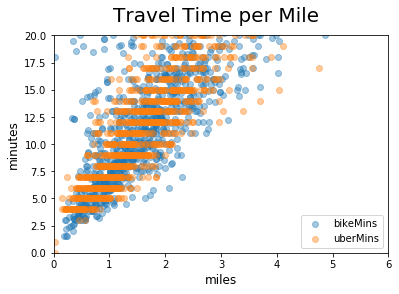

In [87]:
# Plot the uberTripDistance (miles) vs. the bikeMins

fig = plt.figure()
plt.scatter(x = mainTestOutputWithUberDF['uberTripDistance'], y = mainTestOutputWithUberDF['bikeMins'], alpha = 0.4)
plt.scatter(x = mainTestOutputWithUberDF['uberTripDistance'], y = mainTestOutputWithUberDF['uberMins'], alpha = 0.4)
#plt.scatter(x = mainTestOutputWithUberDF['uberTripDistance'], y = mainTestOutputWithUberDF['trainMins'], alpha = 0.1)
fig.suptitle('Travel Time per Mile', fontsize=20)
plt.xlabel('miles', fontsize=12)
plt.ylabel('minutes', fontsize=12)
plt.legend()
# Remove outliers
plt.xlim(0,6)
plt.ylim(0,20)


In [130]:
bikeGraph = nx.Graph()

# Add in all the bike docking station nodes.
for s_id, dockingStation in bikeDockingStations.iterrows():
    
     bikeGraph.add_node(s_id, coordinates=(dockingStation["station__lat"],dockingStation["station__long"]), name=dockingStation['station__name'])

        
#     startLocation = trip['oBike']
#     endLocation = trip['dBike']
#     bikeUberGraph.add_node(1, time='5pm')#     tubeGraph.add_edge(startLocation, endLocation)

In [142]:
for t_id, trip in mainTestOutputWithUberDF.iterrows():
    bikeGraph.add_edge(trip["oBike"], 
                       trip["dBike"], 
                       weight=trip['bikeMins'], 
                       trainMins=trainMins, 
                       uberMins=uberMins )
    
# nx.draw(bikeGraph, nx.get_node_attributes(bikeGraph, 'coordinates'), with_labels=False)


normalize = bikeDockingStations[['station__lat', 'station__long']]
normalize = normed - normed.min()
normalize = normed / normed.max()

locations = dict(zip(bikeDockingStations.index, normed[['station__lat', 'station__long']].values))

p = figure(
    x_range = (.4,.7),
    y_range = (.2,.5),
    height= 700,
    width= 900,
)
for edge in bikeGraph.edges():
    p.line( 
        x= [locations[pt][0] for pt in edge],
        y= [locations[pt][1] for pt in edge],
    )

for node in bikeGraph.nodes():
    x = [locations[node][0]]
    y = [locations[node][1]]
    p.circle(
        x, y, 
        radius = 0.005, 
        #fill_color = pseudocolor(pageranks[node]), 
        line_alpha=0)
    p.text(
        x, y, 
        text = {'value':str(node)}, 
        text_font_size = str(5) + "pt", 
        text_alpha = 1,
        text_align='center',
        text_font_style='bold')
    
show(p)


In [103]:
bikeDockingStations

station__name  \
station__id                                                  
1                               River Street , Clerkenwell   
2                           Phillimore Gardens, Kensington   
3                     Christopher Street, Liverpool Street   
4                          St. Chad's Street, King's Cross   
5                            Sedding Street, Sloane Square   
6                           Broadcasting House, Marylebone   
7                        Charlbert Street, St. John's Wood   
8                                   Maida Vale, Maida Vale   
9                                 New Globe Walk, Bankside   
10                                   Park Street, Bankside   
11                            Brunswick Square, Bloomsbury   
12                                Malet Street, Bloomsbury   
13                                 Scala Street, Fitzrovia   
14                          Belgrove Street , King's Cross   
15                        Great Russell Street, Bloomsbury   
16                         Cartwright Gardens , Bloomsbury   
17                                    Hatton Wall, Holborn   
18                               Drury Lane, Covent Garden   
19                              Taviton Street, Bloomsbury   
21                        Hampstead Road (Cartmel), Euston   
22                            Northington Street , Holborn   
23                                Red Lion Square, Holborn   
24                              British Museum, Bloomsbury   
25                                 Doric Way , Somers Town   
26                             Ampton Street , Clerkenwell   
27                                 Bouverie Street, Temple   
28                              Bolsover Street, Fitzrovia   
29                                Hereford Road, Bayswater   
30                                 Windsor Terrace, Hoxton   
31                                  Fanshaw Street, Hoxton   
...                                                    ...   
802                               Albert Square, Stockwell   
803                             Southwark Street, Bankside   
804                               Good's Way, King's Cross   
805                       Bevington Road, North Kensington   
806                         Handyside Street, King's Cross   
807                  Bevington Road West, North Kensington   
808                        Stockwell Roundabout, Stockwell   
809                          Lincoln's Inn Fields, Holborn   
810                                  Tate Modern, Bankside   
811                         Westferry Circus, Canary Wharf   
812          Here East North, Queen Elizabeth Olympic Park   
813                      New Spring Gardens Walk, Vauxhall   
814                Clapham Road, Lingham Street, Stockwell   
815                          Lambeth Palace Road, Waterloo   
816          Here East South, Queen Elizabeth Olympic Park   
817                            Riverlight South, Nine Elms   
818                           One Tower Bridge, Bermondsey   
819                           Belvedere Road 2, South Bank   
820                                Victory Place, Walworth   
821                Battersea Power Station, Battersea Park   
826                             Allington Street, Victoria   
828                               Normandy Road, Stockwell   
829                                  Wynne Road, Stockwell   
830                                 Sidney Road, Stockwell   
831                            St John's Crescent, Brixton   
832                                Ferndale Road, Brixton.   
833                                  Saltoun Road, Brixton   
835                             Farringdon Street, Holborn   
836                                  York Way, Kings Cross   
838                          Fore Street Avenue, Guildhall   

             station__terminalName  station__lat  station__long  \
station__id                                                       
1   